# RNN y series temporales


In [3]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [4]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [6]:
import requests
import pandas as pd

#A continuación se descarga el dataset de las temperaturas mínimas diarias.
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'


response = requests.get(url, verify=False)


file_path = 'tmp/daily-min-temperatures.csv'  
with open(file_path, 'wb') as file:
    file.write(response.content)


df = pd.read_csv(file_path)
df.head()


C:\Users\EVELYN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'raw.githubusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


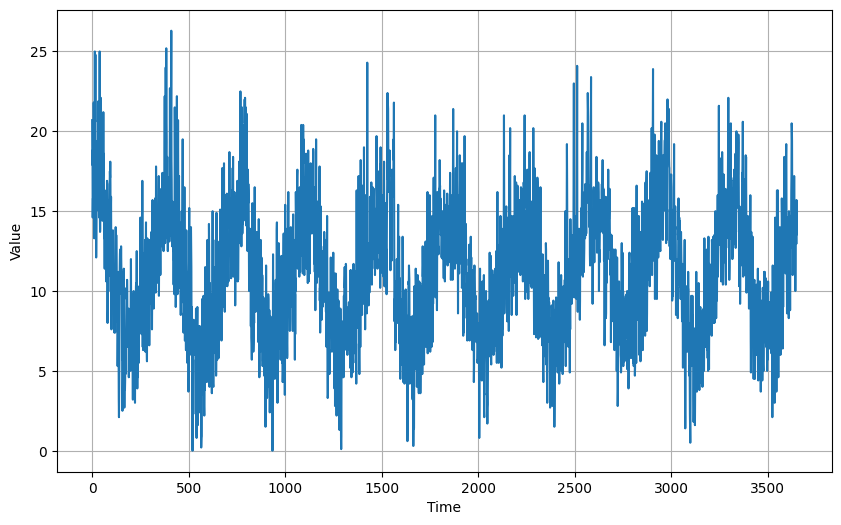

In [7]:
#visualización del dataset
import csv
time_step = []
temps = []

with open('tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [8]:
df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')


temperatures = df['Temp'].values

split_time = 2500
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


time = np.arange(len(temperatures))

# El proceso para particionar el dataset en entrenamiento y validación y luego verificar el resultado
time_train = time[:split_time]
x_train = temperatures[:split_time]
time_valid = time[split_time:]
x_valid = temperatures[split_time:]

print("time_train shape:", time_train.shape)
print("x_train shape:", x_train.shape)
print("time_valid shape:", time_valid.shape)
print("x_valid shape:", x_valid.shape)

# Para la creación de ventanas de tiempo
def create_windowed_dataset(series, window_size):
    dataset = []
    for i in range(len(series) - window_size):
        window = series[i:i + window_size]
        dataset.append(window)
    return np.array(dataset)
x_train_windowed = create_windowed_dataset(x_train, window_size)
x_valid_windowed = create_windowed_dataset(x_valid, window_size)


print("x_train_windowed shape:", x_train_windowed.shape)
print("x_valid_windowed shape:", x_valid_windowed.shape)

time_train shape: (2500,)
x_train shape: (2500,)
time_valid shape: (1150,)
x_valid shape: (1150,)
x_train_windowed shape: (2470, 30)
x_valid_windowed shape: (1120, 30)


In [9]:

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):

    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [10]:
# Montaje de un ejemplo de aplicación en el dataset para verificación
train_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)


for x, y in train_dataset.take(1):
    print("X (train):", x.numpy())
    print("Y (train):", y.numpy())

for x, y in valid_dataset.take(1):
    print("X (valid):", x.numpy())
    print("Y (valid):", y.numpy())

X (train): [[13.  15.  14.7 12.6 12.5 13.5 14.8 17.2  9.7 12.1 12.8 11.2 16.4 15.6
  13.3 11.  11.1 15.  12.8 15.  14.2 14.  15.5 13.3 15.6 15.2 17.4 17.
  15.  13.5]
 [13.7 13.5 10.7 13.  11.6 13.  11.2 13.5 12.9  6.8 10.  14.5 11.7  6.7
   4.6  4.9  7.4  8.3  7.5  6.2  7.8 13.2 11.9  6.5  8.3 12.1  9.3  7.5
   9.3 11. ]
 [13.  15.3 16.3 15.8 17.7 16.3 18.4 15.  10.9 11.4 14.8 12.1 12.8 16.2
  15.5 13.  10.5  9.1 10.5 11.8 12.7 12.7 11.5 13.8 13.3 11.6 15.4 12.4
  16.9 14.7]
 [13.  12.2 10.6 13.  13.  12.2 12.6 18.7 15.2 15.3 13.9 15.8 13.  13.
  13.7 12.  10.8 15.6 15.3 13.9 13.  15.3 16.3 15.8 17.7 16.3 18.4 15.
  10.9 11.4]
 [ 8.   6.1  3.5  3.2  5.7  7.7  9.  10.   6.2  6.9  6.5  6.8  7.   5.2
   3.   5.6  7.9  9.   8.6 10.3 10.5  7.6  9.7 12.5  7.4  7.9  3.9  6.6
   4.6  7. ]
 [ 6.8  5.7  6.1  7.   7.2  6.3  8.8  5.   7.4 10.1 12.   9.   8.9  9.8
   9.   9.2  7.7  8.   6.1  3.5  3.2  5.7  7.7  9.  10.   6.2  6.9  6.5
   6.8  7. ]
 [ 6.2 11.5 10.2  7.9  9.   9.5  6.   8.2  9.2  4.

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [12]:
def model_forecast(model, series, window_size):
    
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast


In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256

In [19]:
x_train = temperatures[:split_time]
window_size = 64
batch_size = 256
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Esta última parte hago para verificar el primer lote del dataset de entrenamiento
for x, y in train_set.take(1):
    print("X (train_set):", x.numpy())
    print("Y (train_set):", y.numpy())

X (train_set): [[[15.5]
  [16.7]
  [16.3]
  ...
  [ 8.3]
  [ 7.5]
  [ 6.2]]

 [[13. ]
  [12.2]
  [10.6]
  ...
  [14.9]
  [16.2]
  [20.3]]

 [[15.7]
  [14.2]
  [ 9.8]
  ...
  [ 6.6]
  [13.2]
  [15.2]]

 ...

 [[17.9]
  [18.8]
  [14.6]
  ...
  [16. ]
  [13.3]
  [14.3]]

 [[ 6.1]
  [ 3.5]
  [ 3.2]
  ...
  [ 9.6]
  [11.4]
  [12.4]]

 [[14.6]
  [17.1]
  [25. ]
  ...
  [15.9]
  [13. ]
  [ 7.6]]]
Y (train_set): [[[16.7]
  [16.3]
  [15.1]
  ...
  [ 7.5]
  [ 6.2]
  [ 7.8]]

 [[12.2]
  [10.6]
  [13. ]
  ...
  [16.2]
  [20.3]
  [22.5]]

 [[14.2]
  [ 9.8]
  [14. ]
  ...
  [13.2]
  [15.2]
  [ 7.6]]

 ...

 [[18.8]
  [14.6]
  [15.8]
  ...
  [13.3]
  [14.3]
  [11.4]]

 [[ 3.5]
  [ 3.2]
  [ 5.7]
  ...
  [11.4]
  [12.4]
  [ 8.9]]

 [[17.1]
  [25. ]
  [15. ]
  ...
  [13. ]
  [ 7.6]
  [11.5]]]


In [22]:
#Para construir la red neuronal tuve que utilizar módulos extra como Input, Conv1D, LSTM, Dense y Lambda que necesité importar desde tensorflow 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Lambda


input_layer = Input(shape=[None, 1])
conv1d_layer = Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation='relu')(input_layer)
lstm_layer1 = LSTM(64, return_sequences=True)(conv1d_layer)
lstm_layer2 = LSTM(64, return_sequences=True)(lstm_layer1)
dense_layer1 = Dense(30)(lstm_layer2)
dense_layer2 = Dense(10)(dense_layer1)
output_layer = Dense(1)(dense_layer2)
scaled_output_layer = Lambda(lambda x: x * 400)(output_layer)  # Escalar la salida

model = Model(inputs=input_layer, outputs=scaled_output_layer)


model.compile(loss='mse', optimizer='adam')

# También presento un resumen del modelo creado 

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 conv1d_2 (Conv1D)           (None, None, 32)          192       
                                                                 
 lstm_4 (LSTM)               (None, None, 64)          24832     
                                                                 
 lstm_5 (LSTM)               (None, None, 64)          33024     
                                                                 
 dense_6 (Dense)             (None, None, 30)          1950      
                                                                 
 dense_7 (Dense)             (None, None, 10)          310       
                                                                 
 dense_8 (Dense)             (None, None, 1)           11  

In [23]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))


model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(None, 1)),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100

10/10 [==============================] - 1s 24ms/step - loss: 50.9578 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 0s 23ms/step - loss: 50.9577 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 0s 24ms/step - loss: 50.9577 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 0s 24ms/step - loss: 50.9577 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 0s 29ms/step - loss: 50.9577 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 0s 26ms/step - loss: 50.9576 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 0s 25ms/step - loss: 50.9575 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 0s 19ms/step - loss: 50.9575 - lr: 2.2387e-08
Epoch 9/100
10/10 [==============================] - 0s 25ms/step - loss: 50.9574 - lr: 2.5119e-08
Epoch 10/100
10/10 [==============================] - 0s 26ms/step - loss: 50.9573 - lr: 2.8184e-08
Epoch 11

In [24]:
#Utilicé el modelo sequential y luego añadí los parámetros especificados: 

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=optimizer, 
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, None, 10)          20        
                                                                 
 dense_10 (Dense)            (None, None, 1)           11        
                                                                 
Total params: 31 (124.00 Byte)
Trainable params: 31 (124.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 1s 26ms/step - loss: 3.4697 - mean_absolute_error: 3.9520 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 0s 28ms/step - loss: 3.4696 - mean_absolute_error: 3.9519 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 0s 27ms/step - loss: 3.4695 - mean_absolute_error: 3.9518 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 0s 27ms/step - loss: 3.4693 - mean_absolute_error: 3.9517 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 0s 28ms/step - loss: 3.4691 - mean_absolute_error: 3.9515 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 0s 26ms/step - loss: 3.4690 - mean_absolute_error: 3.9513 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 1s 24ms/step - loss: 3.4687 - mean_absolute_error: 3.9511 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 0s 27ms/step - loss: 3.4685 - mean_absolute_error: 

(1e-08, 0.0001, 0.0, 60.0)

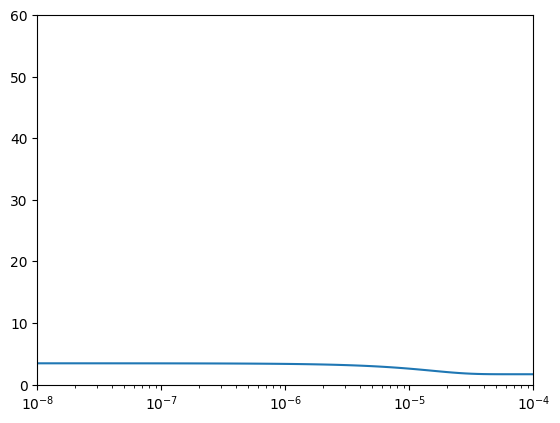

In [26]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [27]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=60, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)


model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=optimizer, 
              metrics=[tf.keras.metrics.MeanAbsoluteError()])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 60)          360       
                                                                 
 lstm (LSTM)                 (None, None, 64)          32000     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          33024     
                                                                 
 dense (Dense)               (None, None, 30)          1950      
                                                                 
 dense_1 (Dense)             (None, None, 10)          310       
                                                                 
 dense_2 (Dense)             (None, None, 1)           11        
                                                                 
 lambda (Lambda)             (None, None, 1)           0

In [29]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)


lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))


model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=optimizer, 
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 60)          360       
                                                                 
 lstm (LSTM)                 (None, None, 64)          32000     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          33024     
                                                                 
 dense (Dense)               (None, None, 30)          1950      
                                                                 
 dense_1 (Dense)             (None, None, 10)          310       
                                                                 
 dense_2 (Dense)             (None, None, 1)           11        
                                                                 
 lambda (Lambda)             (None, None, 1)           0

In [30]:
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 6s 92ms/step - loss: 32.9322 - mean_absolute_error: 33.4314
Epoch 2/150
25/25 [==============================] - 2s 82ms/step - loss: 21.4328 - mean_absolute_error: 21.9311
Epoch 3/150
25/25 [==============================] - 2s 76ms/step - loss: 11.8669 - mean_absolute_error: 12.3590
Epoch 4/150
25/25 [==============================] - 2s 68ms/step - loss: 9.7814 - mean_absolute_error: 10.2689
Epoch 5/150
25/25 [==============================] - 2s 65ms/step - loss: 9.7163 - mean_absolute_error: 10.2038
Epoch 6/150
25/25 [==============================] - 2s 62ms/step - loss: 9.6360 - mean_absolute_error: 10.1236
Epoch 7/150
25/25 [==============================] - 2s 61ms/step - loss: 9.5683 - mean_absolute_error: 10.0558
Epoch 8/150
25/25 [==============================] - 2s 71ms/step - loss: 9.5019 - mean_absolute_error: 9.9894
Epoch 9/150
25/25 [==============================] - 2s 82ms/step - loss: 9.4372 - mean_absolute_error

In [31]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

113/113 [==============================] - 3s 19ms/step


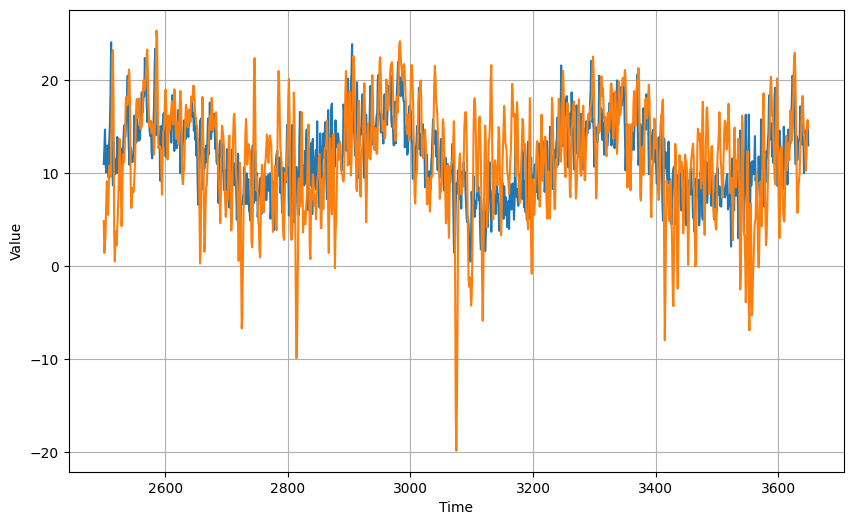

In [32]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [33]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

4.4308014

In [34]:
print(rnn_forecast)

[ 4.8608246  1.425201   2.5264924 ... 15.3126955 15.666455  14.822274 ]


In [35]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


loss=history.history['loss']

epochs=range(len(loss)) 

<Figure size 640x480 with 0 Axes>

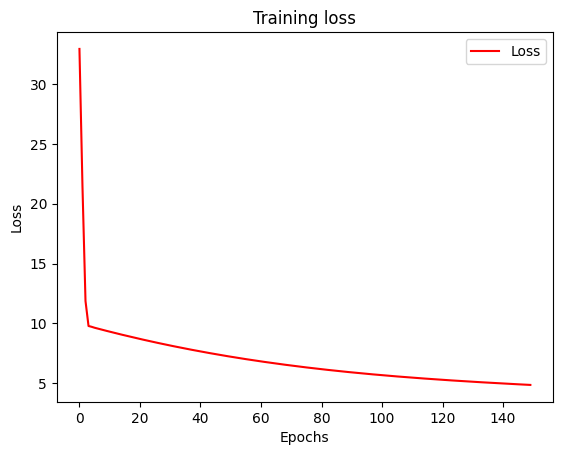

<Figure size 640x480 with 0 Axes>

In [36]:

# Pérdida de entrenamiento y validación por epoch

plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

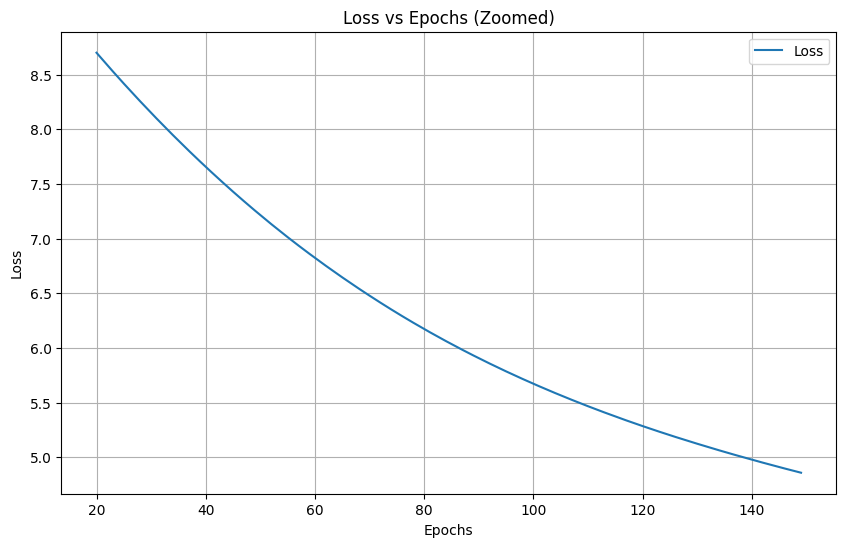

In [37]:
loss = history.history['loss']
epochs = range(len(loss))

zoomed_loss = loss[20:150]  
zoomed_epochs = range(20, 20 + len(zoomed_loss))

plt.figure(figsize=(10, 6))
plt.plot(zoomed_epochs, zoomed_loss, label='Loss')
plt.title('Loss vs Epochs (Zoomed)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()